## Handwritten digit recognition with MNIST from `torchvision.datasets`

## 1. Getting a dataset

In [1]:
# Import PyTorch
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import torchvision
from torchvision import datasets
from torchvision import transforms

# Setup training data - MNIST
train_data = datasets.MNIST(
    root="MNIST",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="MNIST",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_data, test_data

100%|██████████| 9912422/9912422 [00:00<00:00, 79749469.61it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33518454.30it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 42108447.37it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13165534.74it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: MNIST
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: MNIST
     Split: Test
     StandardTransform
 Transform: ToTensor())

### 1.1 Input and output shapes of a computer vision model

In [2]:
# See the first training sample
image, label = train_data[0][0], train_data[0][1]
print(f"Shape of the sample image: {image.shape} -> [color_channels, height, width]")

Shape of the sample image: torch.Size([1, 28, 28]) -> [color_channels, height, width]


In [3]:
# check the lengths of the train and test data
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [4]:
# See the class names and labels
class_names = train_data.classes
class_names_idx = train_data.class_to_idx
print(f"Class names: {class_names}")

Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


### 1.2 Visualizing the data

Image shape: torch.Size([1, 28, 28])


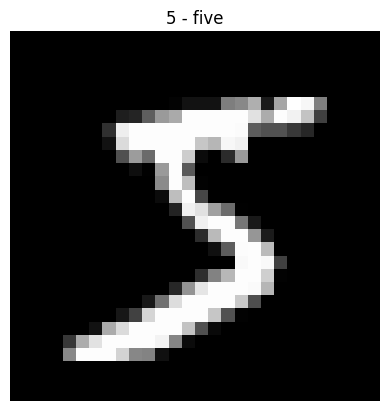

In [5]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False);

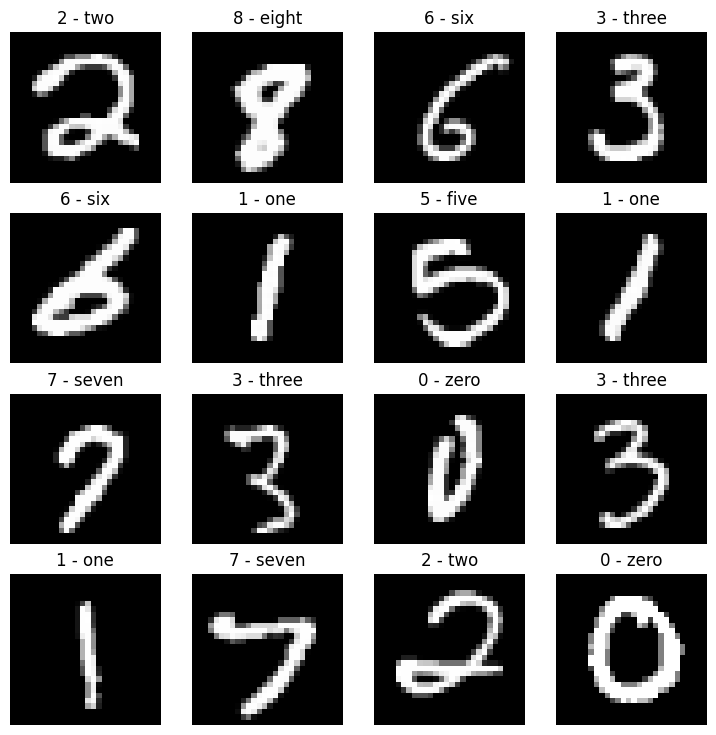

In [6]:
# visualize more digit images
import matplotlib.pyplot as plt
import random
#random.seed(34)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = random.randint(0, len(train_data))
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis("off")
plt.show()

## 2. Prepare DataLoader

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32 # batch size hyperparameters

# turn datasets into iterable (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 5, label size:torch.Size([])


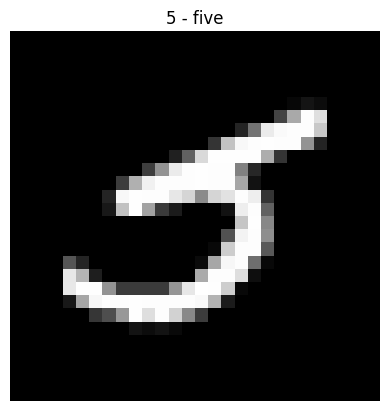

In [9]:
# PLot a random sample
random_idx = random.randint(0, len(train_features_batch))
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False);
print(f"Image size: {image.shape}\nLabel: {label}, label size:{label.shape}")

## 3. Build a CNN model

In [10]:
from torch import nn
class ModelCNN_MNIST(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

torch.manual_seed(34)
model = ModelCNN_MNIST(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
    ).to(device)

model

ModelCNN_MNIST(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 3.1 Try a forward pass on a single image

In [11]:
# 1. Get a batch of images and labels
image_batch, label_batch = train_features_batch[0], train_labels_batch[0]
print(f"Single image size: {image_batch.shape}")

# 2 . Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
  pred = model(image_batch.unsqueeze(dim=0).to(device))

# 4 Print out
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_batch}")

Single image size: torch.Size([1, 28, 28])
Output logits:
tensor([[-0.0170, -0.0226, -0.0282,  0.0028,  0.0051, -0.0224,  0.0182,  0.0473,
         -0.0252, -0.0027]])

Output prediction probabilities:
tensor([[0.0987, 0.0982, 0.0976, 0.1007, 0.1009, 0.0982, 0.1023, 0.1053, 0.0979,
         0.1002]])

Output prediction label:
tensor([7])

Actual label:
9


### 3.2 Get an idea of shapes going through the model

In [12]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 1, 28, 28]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelCNN_MNIST                           [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─ReLU: 2-2                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 10, 28, 28]           910
│    └─ReLU: 2-4                         [1, 10, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 10, 14, 14]           --
├─Sequential: 1-2                        [1, 10, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 10, 14, 14]           910
│    └─ReLU: 2-7                         [1, 10, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 10, 14, 14]           910
│    └─ReLU: 2-9                         [1, 10, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 10, 7, 7]             --
├─Sequentia

### 3.3 Create train and test loop functions

In [13]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # print("Train - X:", X.shape, "y:", y.shape)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [14]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # print("Test - X:", X.shape, "y:", y.shape)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 3.4 Create a `train()` function to combine `train_step()` and `test_step()`

In [15]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [16]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
# model = ModelCNN_MNIST(input_shape=1, # number of color channels
#                         hidden_units=10,
#                         output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
# Train model
model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2160 | train_acc: 0.9329 | test_loss: 0.0788 | test_acc: 0.9744
Epoch: 2 | train_loss: 0.0733 | train_acc: 0.9773 | test_loss: 0.0540 | test_acc: 0.9817
Epoch: 3 | train_loss: 0.0576 | train_acc: 0.9819 | test_loss: 0.0498 | test_acc: 0.9834
Epoch: 4 | train_loss: 0.0484 | train_acc: 0.9851 | test_loss: 0.0412 | test_acc: 0.9879
Epoch: 5 | train_loss: 0.0401 | train_acc: 0.9878 | test_loss: 0.0384 | test_acc: 0.9878
Total training time: 313.948 seconds


## 4. Make predictions

In [17]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [18]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# view the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

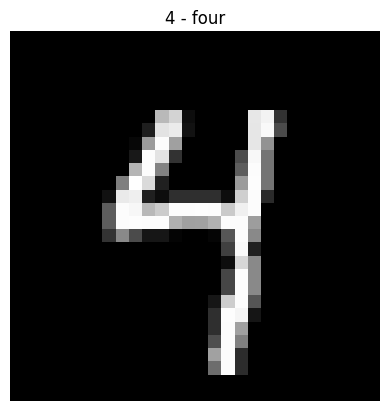

In [19]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])
plt.axis(False);

In [20]:
# make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

# convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
print(f"Predictions:\n{pred_classes}\nTruth:\n{test_labels}")

Predictions:
tensor([4, 8, 6, 0, 1, 0, 4, 3, 2])
Truth:
[4, 8, 6, 0, 1, 0, 4, 3, 2]


Predictions:
tensor([0, 5, 7, 3, 2, 6, 3, 1, 6])
Truth:
[0, 5, 7, 3, 2, 6, 3, 1, 6]


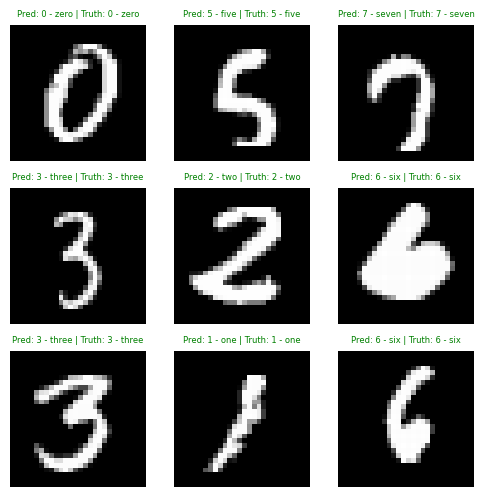

In [21]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

# convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
print(f"Predictions:\n{pred_classes}\nTruth:\n{test_labels}")

# plot predictions
plt.figure(figsize=(6, 6))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
  # create subplot
  plt.subplot(nrows, ncols, i+1)
  # plot
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  # get the truth label
  truth_label = class_names[test_labels[i]]
  # create a title
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=6, c="g")
  else:
    plt.title(title_text, fontsize=6, c="r")
  plt.axis(False);

In [22]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.7 MB/s eta 0:00:00
mlxtend version: 0.23.0


In [23]:
# Make predictions across all test data
from tqdm.auto import tqdm
model.eval()
y_preds = []
with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    # Make sure data on right device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred_logits = model(X)
    # Logits -> Pred probs -> Pred label
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    # Append the labels to the preds list
    y_preds.append(y_pred_labels)
  y_preds=torch.cat(y_preds).cpu()
len(y_preds)

0it [00:00, ?it/s]

10000

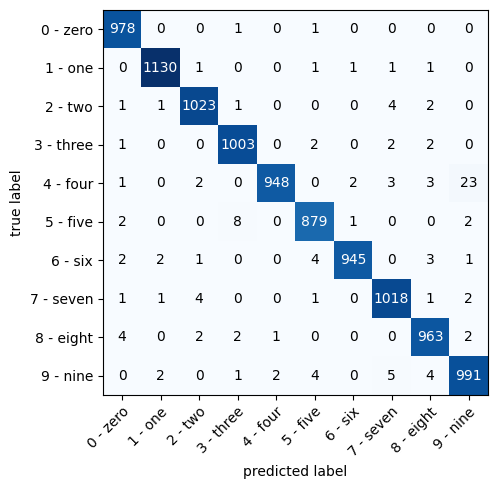

In [24]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(8, 5)
)
